[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/pixeltable/pixeltable/blob/release/docs/release/tutorials/working-with-hugging-face.ipynb) [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pixeltable/pixeltable/blob/release/docs/release/tutorials/working-with-hugging-face.ipynb)

# Working with Hugging Face

Pixeltable unifies data and computation into a table interface. In this tutorial, we'll go into more depth on the Hugging Face integration between datasets and how Hugging Face models can be incorporated into Pixeltable workflows to run models locally.

In [ ]:
%pip install pixeltable datasets -qU

In [ ]:
import pixeltable as pxt
import datasets

Now let's load the Hugging Face dataset. You can learn more about the different load methods [here](https://huggingface.co/docs/datasets/en/package_reference/loading_methods)

In [ ]:
Padoru = datasets.load_dataset("not-lain/padoru", split='train').select_columns(['Image', 'ImageSize', 'Name', 'ImageSource'])

README.md:   0%|          | 0.00/803 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/152M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/382 [00:00<?, ? examples/s]

It preserves the Hugging Face information about whether the data is part of the *test*, *train* or *validation* split.

In [ ]:
Padoru

Dataset({
    features: ['Image', 'ImageSize', 'Name', 'ImageSource'],
    num_rows: 382
})

## Create a Pixeltable Table from a Hugging Face Dataset

Now we create a table and Pixeltable will map column types as needed. Check out other ways to bring data into Pixeltable with [pixeltable.io](https://pixeltable.github.io/pixeltable/api/io/) such as csv, parquet, pandas, json and others.

In [ ]:
t = pxt.io.import_huggingface_dataset('padoru', Padoru)

Creating a Pixeltable instance at: /root/.pixeltable
Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/root/.pixeltable/pgdata
Created table `padoru_tmp_48836957`.
Inserting rows into `padoru_tmp_48836957`: 126 rows [00:00, 4905.16 rows/s]
Inserted 126 rows with 0 errors.
Inserting rows into `padoru_tmp_48836957`: 126 rows [00:00, 5605.04 rows/s]
Inserted 126 rows with 0 errors.
Inserting rows into `padoru_tmp_48836957`: 126 rows [00:00, 5182.47 rows/s]
Inserted 126 rows with 0 errors.
Inserting rows into `padoru_tmp_48836957`: 4 rows [00:00, 735.65 rows/s]
Inserted 4 rows with 0 errors.


Image  ImageSize  \
0  <PIL.WebPImagePlugin.WebPImageFile image mode=...     240993   
1  <PIL.WebPImagePlugin.WebPImageFile image mode=...     993097   
2  <PIL.WebPImagePlugin.WebPImageFile image mode=...     255549   

            Name                                     ImageSource  
0        AI-Chan  https://knowyourmeme.com/photos/1439336-padoru  
1       Platelet  https://knowyourmeme.com/photos/1438687-padoru  
2  Nezuko Kamado  https://knowyourmeme.com/photos/1568913-padoru
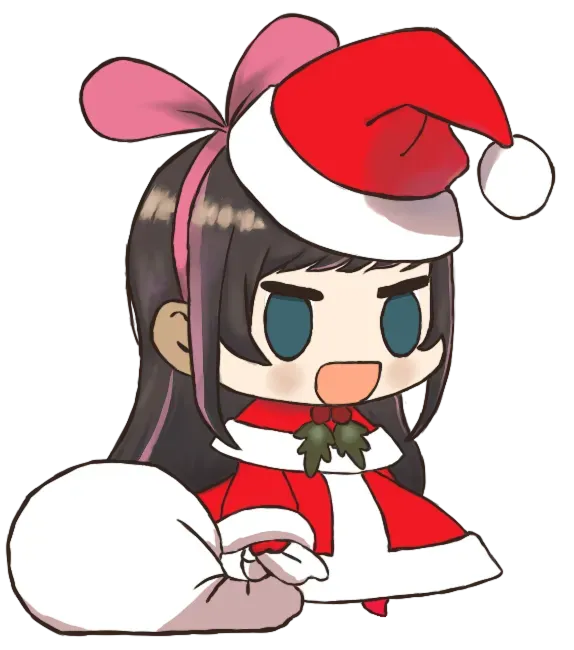
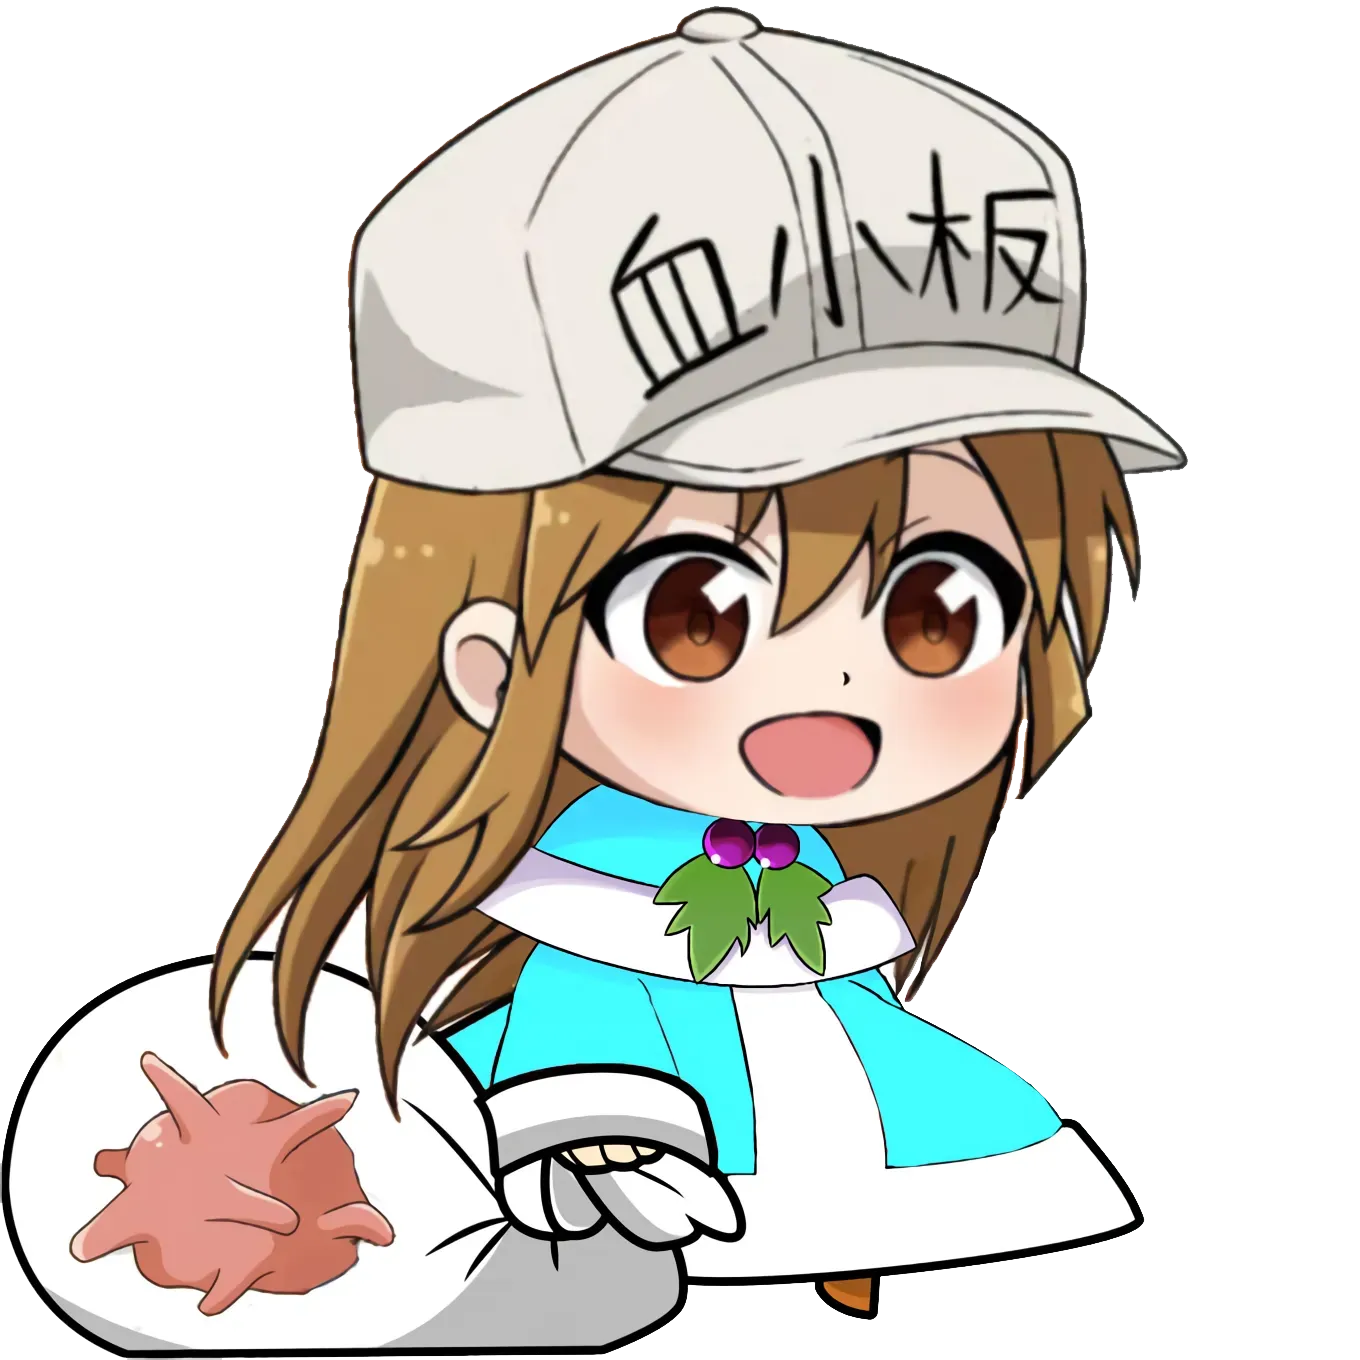
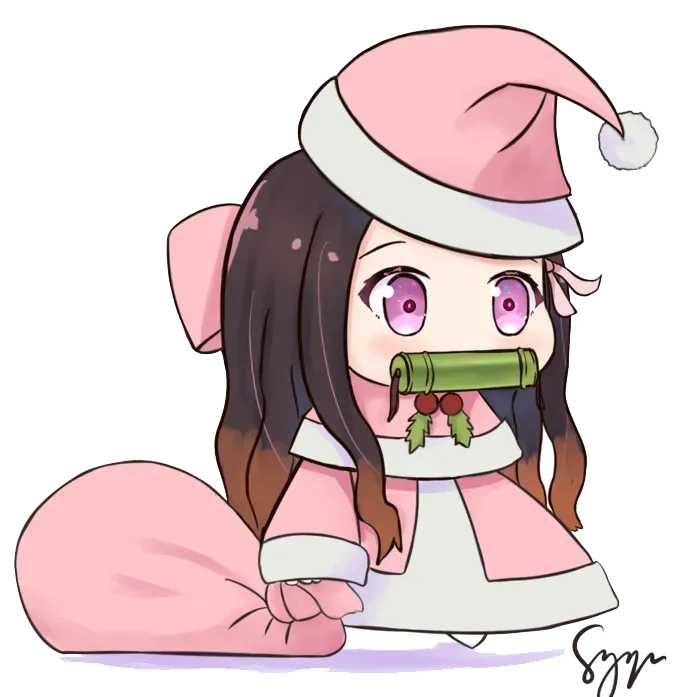

In [ ]:
t.show(3)

## Leveraging Hugging Face Models with Pixeltable's Embedding Functionality

Pixeltable contains a built-in adapter for certain model families, so all we have to do is call the [Pixeltable function for Hugging Face](https://pixeltable.github.io/pixeltable/api/functions/huggingface/). A nice thing about the Huggingface models is that they run locally, so you don't need an account with a service provider in order to use them.

Pixeltable can also create and populate an index with `table.add_embedding_index()` for string and image embeddings. That definition is persisted as part of the table's metadata, which allows Pixeltable to maintain the index in response to updates to the table.

In this example we are using `CLIP`. You can use any embedding function you like, via Pixeltable's UDF mechanism (which is described in detail our [guide to user-defined functions](https://docs.pixeltable.com/docs/user-defined-functions-udfs).

In [ ]:
from pixeltable.functions.huggingface import clip_image, clip_text
import PIL.Image

# create a udf that takes a single string, to use as an embedding function
@pxt.expr_udf
def str_embed(s: str):
    return clip_text(s, model_id='openai/clip-vit-base-patch32')

# create a udf that takes a single image, to use as an embedding function
@pxt.expr_udf
def img_embed(Image: PIL.Image.Image):
    return clip_image(Image, model_id='openai/clip-vit-base-patch32')

# create embedding index on the 'Image' column
t.add_embedding_index('Image', string_embed=str_embed, image_embed=img_embed)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Computing cells:   0%|                                                  | 0/382 [00:00<?, ? cells/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Computing cells: 100%|████████████████████████████████████████| 382/382 [00:36<00:00, 10.40 cells/s]


Image       sim
0  <PIL.WebPImagePlugin.WebPImageFile image mode=...  1.000000
1  <PIL.WebPImagePlugin.WebPImageFile image mode=...  0.962924
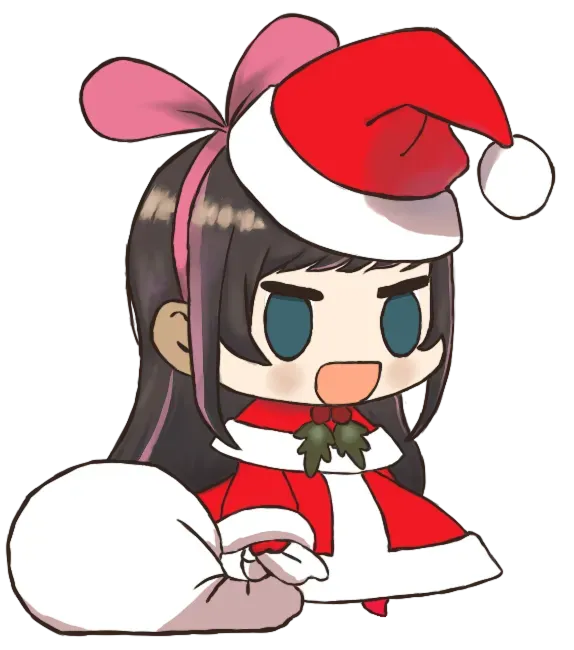
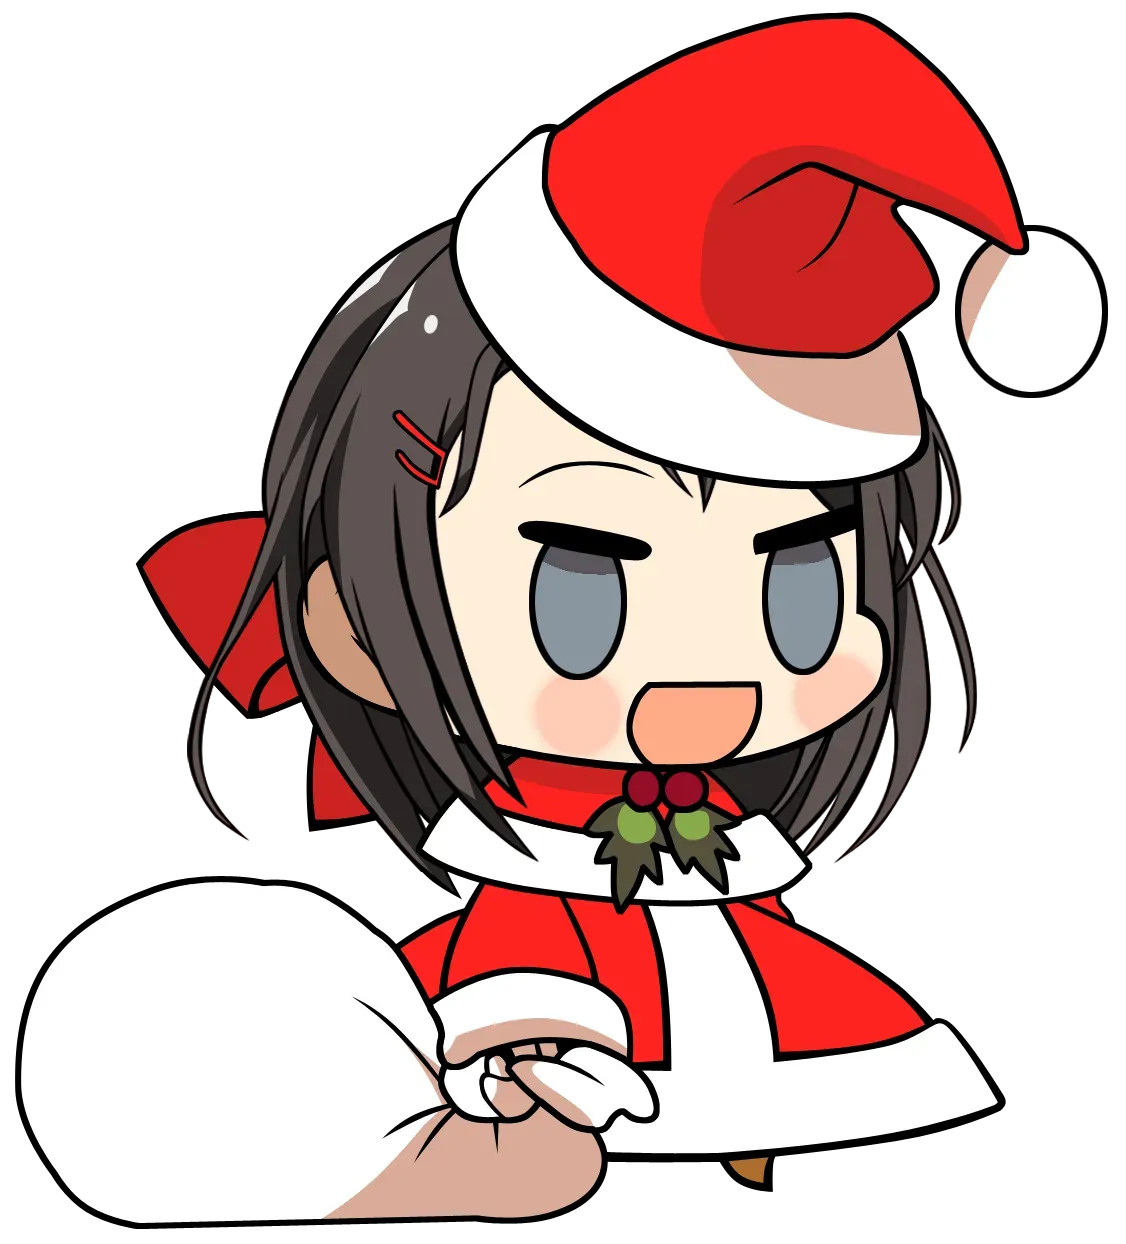

In [ ]:
sample_img = t.select(t.Image).collect()[6]['Image']

sim = t.Image.similarity(sample_img)

# use 'similarity()' in the order_by() clause and apply a limit in order to utilize the index
res = t.order_by(sim, asc=False).limit(2).select(t.Image, sim=sim).collect()
res

You can learn more about how to leverage indexes in detail with our tutorial: [Working with Embedding and Vector Indexes](https://docs.pixeltable.com/docs/embedding-vector-indexes)